# Sample cuts

In [1]:
import snpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

from multiprocessing import Pool

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
DATA_DIR = 'csp_data'
PROCESSES = 8

SNooPy version: v2.6.0


___
## Testing SNooPy

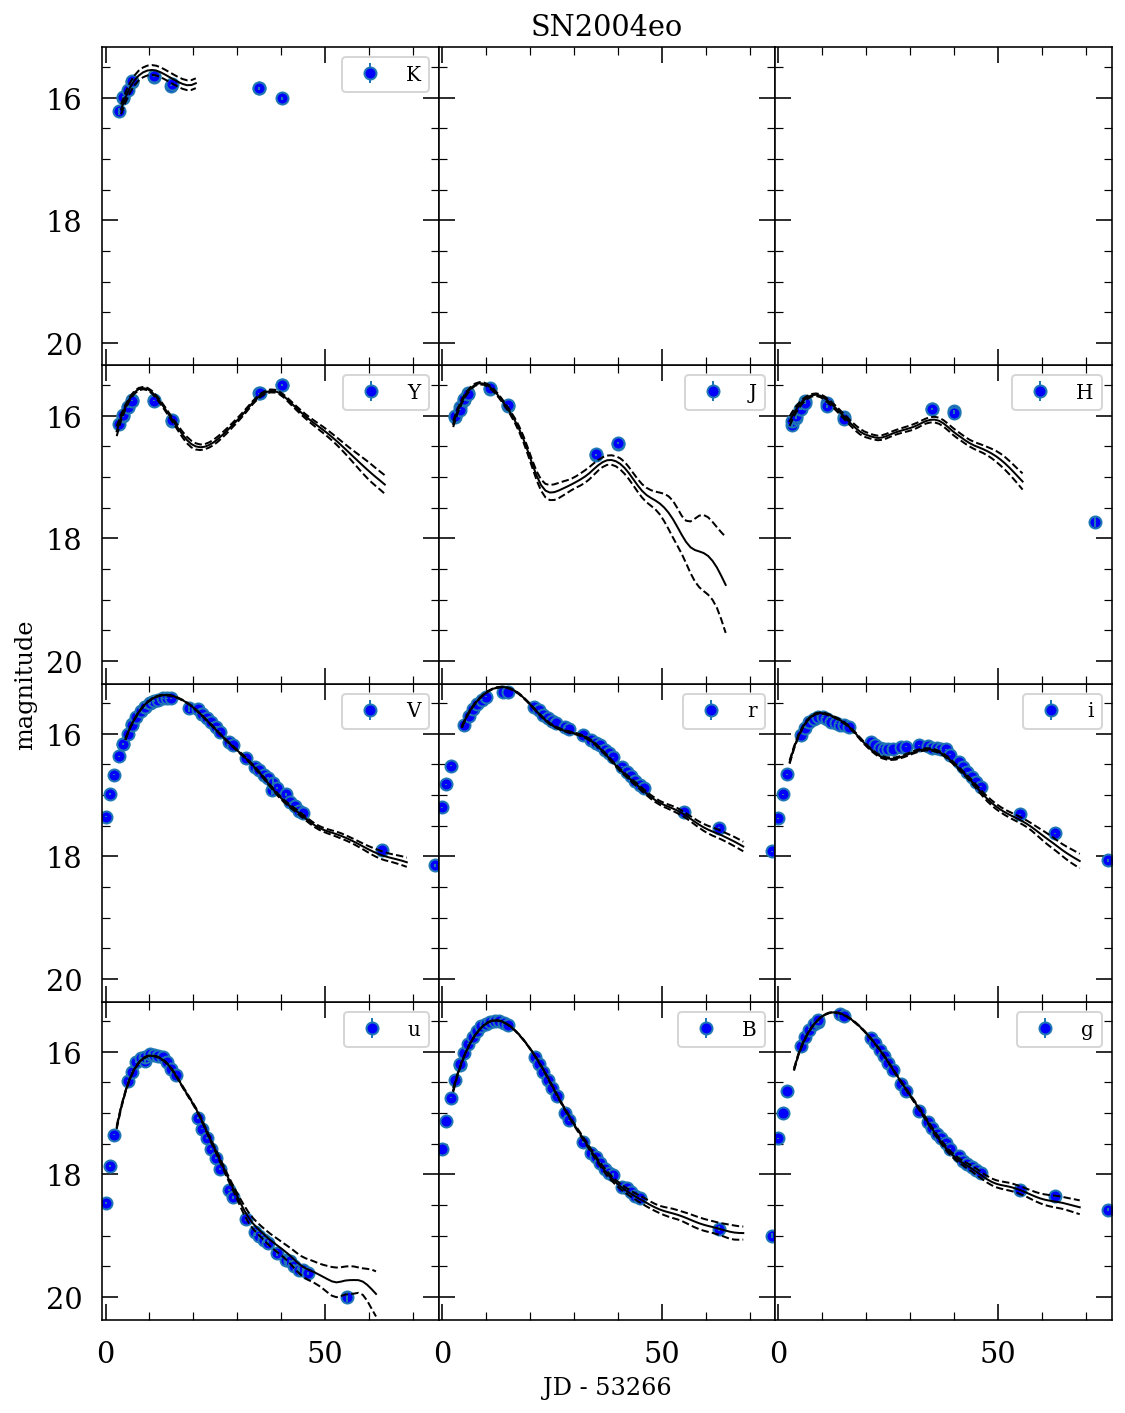

In [2]:
sn_name = 'SN2004eo'
sn_file = os.path.join(DATA_DIR, f'{sn_name}_snpy.txt')
sn = snpy.import_lc(sn_file)
                 
sn.choose_model(SNOOPY_MODEL)
sn.fit(['g'])
sn.fit()

In [3]:
sn.summary()

--------------------------------------------------------------------------------
SN  SN2004eo
z = 0.0157          zcmb = 0.0147          ra=308.22580         dec=  9.92850 
Data in the following bands: g,  r,  i,  u,  B,  V,  J,  H,  K,  Y,  
Fit results (if any):
   st = 0.819  +/-  0.005  +/- 0.030 (sys)
   Tmax = 53278.558  +/-  0.039  +/- 0.340 (sys)
   gmax = 15.034  +/-  0.008  +/- 0.014 (sys)
   rmax = 15.026  +/-  0.007  +/- 0.022 (sys)
   imax = 15.525  +/-  0.009  +/- 0.022 (sys)
   umax = 15.568  +/-  0.013  +/- 0.030 (sys)
   Bmax = 15.114  +/-  0.007  +/- 0.012 (sys)
   Vmax = 15.060  +/-  0.008  +/- 0.019 (sys)
   Jmax = 15.418  +/-  0.028  +/- 0.044 (sys)
   Hmax = 15.626  +/-  0.038  +/- 0.055 (sys)
   Kmax = 15.581  +/-  0.090
   Ymax = 15.475  +/-  0.025  +/- 0.050 (sys)


___
## SNe with g, J and H bands

All SNe have B, V and r bands (tested)

In [2]:
def extract_bands(sn_file):
    """Reads a SN file with SNooPy format and
    extracts the bands/filters used.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    bands: list
        List of bands for a given SN.
    """
    
    bands = []
    with open(sn_file, 'r') as file:
        for line in file:
            if 'filter' in line:
                band = line.split()[-1]
                bands.append(band)
                
    return bands

In [11]:
sn_files = [file for file in glob.glob(f'{DATA_DIR}/*.txt')]

count = 0
with open('sne_wo_JorH.txt', 'w') as fout:
    for sn_file in sn_files:
        file_basename = sn_file.split('/')[-1]
        sn_name = file_basename.split('_')[0]
        bands = extract_bands(sn_file)

        missing_bands = [band for band in ['g', 'J', 'H'] 
                                         if band not in bands]
        if len(missing_bands)>0:
            print(f'{sn_name} does not have {missing_bands} ---> {bands}')
            bands_str = ''.join(band+'-' for band in bands)[:-1]
            fout.write(f'{sn_name} \t{bands_str}\n')
            count += 1
            
print(f'{count} SNe out of {len(sn_files)} without g, J or H bands.')        

SN2011jt does not have ['J', 'H'] ---> ['B', 'V', 'i', 'g', 'r', 'u']
SN2009P does not have ['H'] ---> ['g', 'r', 'i', 'u', 'V', 'B', 'Y', 'J']
CSP13abm does not have ['J', 'H'] ---> ['B', 'V', 'g', 'r', 'i', 'u']
LSQ12cda does not have ['J', 'H'] ---> ['V', 'B', 'i', 'r', 'g', 'Y']
PTF14uo does not have ['g', 'J', 'H'] ---> ['V', 'B', 'r', 'i', 'Y']
SN2014at does not have ['J', 'H'] ---> ['i', 'r', 'g', 'u', 'V', 'B']
PTF13dwl does not have ['J', 'H'] ---> ['V', 'B', 'g', 'r', 'i', 'u', 'Y']
PTF13dyt does not have ['g', 'J', 'H'] ---> ['B', 'V', 'r', 'i', 'Y']
SN2012G does not have ['J', 'H'] ---> ['r', 'i', 'g', 'u', 'B', 'V']
SN2012hl does not have ['g', 'J', 'H'] ---> ['B', 'V', 'r', 'i']
SN2005hj does not have ['H'] ---> ['g', 'r', 'i', 'u', 'V', 'B', 'Y', 'J']
SN2006ef does not have ['J', 'H'] ---> ['g', 'r', 'i', 'u', 'V', 'B']
LSQ12hvj does not have ['g'] ---> ['Y', 'H', 'J', 'B', 'V', 'r', 'i']
SN2008bz does not have ['H'] ---> ['V', 'B', 'u', 'g', 'r', 'i', 'J', 'Y']
CSP13N d

## SNe with coverage around optical peak

First we remove those SNe without J or H bands found above.
To have "good" coverage of the optical peak, we requiere to have at least one data point 2 days before B band maximum in observed B, g, V or r bands.

In [5]:
def check_opt_peak(sn_file):
    '''Fits a SN with SNooPy and checks whether the optical
    peak is covered.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    The SN name if the peak is not covered.
    '''
    
    sn = snpy.import_lc(sn_file)

    # remove bands with no photometry (no idea why they are empty)
    for band in sn.allbands():
        band_mag = sn.data[band].magnitude
        if len(band_mag)==0:
            sn.data.pop(band)

    # fit opt bands only for quicker results
    bands2fit = [band for band in ['B', 'g', 'V', 'r'] 
                     if band in sn.allbands()]
    if sn.name in ['SN2005ke', 'SN2006mr']:
        bands2fit = ['B', 'g', 'V']
    sn.choose_model(SNOOPY_MODEL)

    try:
        sn.fit(bands2fit)
    except Exception as message:
        print(f'Unable to fit {sn.name}: {message}')
        return sn.name

    # check if there is optical coverage before B max
    opt_peak_covered = False
    for band in sn.allbands():
        if band in ['B', 'g', 'V', 'r']:
            times = sn.data[band].get_t()  # observed epochs
            # we require data at least 2 days before optical peak
            if np.any(times<=-2):
                opt_peak_covered = True
                break

    # save the plots of the SNe w/o optical peak coverage
    if not opt_peak_covered:
        print(f'{sn.name} does not have coverage before B max')
        sn.plot(outfile=f'opt_cuts_fits/{sn.name}.jpeg')
        return sn.name

In [6]:
# SNe to remove
df = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
files2remove = [f'{DATA_DIR}/{name}_snpy.txt' for name in df.name.values]

sn_files = [file for file in glob.glob(f'{DATA_DIR}/*.txt') if file not in files2remove]

In [7]:
print(f'Fitting {len(sn_files)} SNe ({len(files2remove)} SNe removed so far after cuts)')
results_opt = Pool(PROCESSES).map(check_opt_peak, (sn_file for sn_file in sn_files))

with open('sne_wo_opt_max.txt', 'w') as fout:   
    for sn_name in results_opt:
        if sn_name is not None:
            fout.write(sn_name + '\n')
        
cuts_count = len([sn_name for sn_name in results_opt if sn_name is not None])
print(f'\n{cuts_count} SNe without optical peak coverage (some are discarded for other reasons)')

Fitting 226 SNe (110 SNe removed so far after cuts)
SN2014dn does not have coverage before B max
SN2013az does not have coverage before B max
SN2008cf does not have coverage before B max
ASAS15dd does not have coverage before B max
SN2008hu does not have coverage before B max
SN2013hn does not have coverage before B max
CSP13N does not have coverage before B max
ASAS15al does not have coverage before B max
LSQ13pf does not have coverage before B max
ASAS15fr does not have coverage before B max
PTF11pra does not have coverage before B max
Unable to fit SN2013bc: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
SN2008ff does not have coverage before B max
SN2007ux does not have coverage before B max
SN2007as does not have coverage before B max
SN2008bt does not have coverage before B max
SN2008cc does not have coverage before B max
SN2006ev does not have coverage before B max
SN2008bq does not have cove

There are two main errors when the fits fail:
        
1) `RuntimeError: Error:  Covariance Matrix is singular. Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.`

2) `RuntimeError: All weights for filter X are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.` (for different filters)

Note that SN2007al, SN2008bi, SN2013bc and SN2014ba fail, but they do not have B-band peak coverage. SN2007ax doesn't look normal, so I do not include it either.

___
## SNe w/o NIR peak coverage

We need to remove those SNe without J or H bands and those without optical peak coverage first.
Then we can see which SNe have their NIR peka covered.

In [8]:
def check_NIR_peak(sn_file):
    '''Fits a SN with SNooPy and checks whether the NIR
    peak is covered.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    The SN name if the peak is not covered.
    '''
    
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)

    if sn.name=='SN2008fp':
        sn.data.pop('K')

    try:
        sn.fit()
    except Exception as message:
        try:
            split_mssg = message.args[0].split()
            filt_ind = split_mssg.index('filter') + 1
            filt = split_mssg[filt_ind]
            if filt not in ['J', 'H']:
                sn.data.pop(filt)
                sn.fit()
            else:
                print(f'Unable to fit {sn.name}: {message}')
                return  sn.name
        except Exception as message2:
            print(f'Unable to fit {sn.name}: {message}')
            return  sn.name

    # check if there is NIR coverage before NIR max
    nir_peak_covered = False
    for band in sn.allbands():
        if band in ['J', 'H']:

            model_times = np.arange(sn.Tmax-20, sn.Tmax+40, 0.1)
            model_mag, _, mask = sn.model(band, model_times)
            model_phases  = model_times[mask]-sn.Tmax 
            model_mag = model_mag[mask]

            phases = sn.data[band].get_t()  # observed phases w.r.t. Tmax
            first_epoch = phases[0]
            last_epoch = phases[-1]

            peak_model_id = np.argmin(model_mag)
            peak_model_phase = model_phases[peak_model_id]

            if first_epoch<peak_model_phase and last_epoch>peak_model_phase:
                nir_peak_covered = True
                break

    # save the plots of the SNe w/o optical peak coverage
    if not nir_peak_covered:
        print(f'{sn.name} does not have coverage before NIR max')
        sn.plot(outfile=f'nir_cuts_fits/{sn.name}.jpeg')
        return sn.name

In [9]:
# SNe to remove
df1 = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
df2 = pd.read_csv('sne_wo_opt_max.txt', names=['name', 'comment'], delim_whitespace=True)
del_df = pd.concat([df1, df2])
files2remove = [f'{DATA_DIR}/{name}_snpy.txt' for name in list(del_df.name.values)]

sn_files = [file for file in glob.glob(f'{DATA_DIR}/*.txt') if file not in files2remove]

In [10]:
print(f'Fitting {len(sn_files)} SNe ({len(files2remove)} SNe removed so far after cuts)')
results_NIR = Pool(PROCESSES).map(check_NIR_peak, (sn_file for sn_file in sn_files))

with open('sne_wo_nir_max.txt', 'w') as fout:   
    for sn_name in results_NIR:
        if sn_name is not None:
            fout.write(sn_name + '\n')
        
cuts_count = len([sn_name for sn_name in results_NIR if sn_name is not None])
print(f'\n{cuts_count} SNe without NIR peak coverage (some are discarded for other reasons)')

Fitting 152 SNe (184 SNe removed so far after cuts)
ASAS15hf does not have coverage before NIR max
LSQ14ahm does not have coverage before NIR max
ASAS14hr does not have coverage before NIR max
PTF11pbp does not have coverage before NIR max
ASAS15be does not have coverage before NIR max
PS1-14xw does not have coverage before NIR max
ASAS15gr does not have coverage before NIR max
SN2005na does not have coverage before NIR max
LSQ11ot does not have coverage before NIR max
SN2006D does not have coverage before NIR max
SN2005iq does not have coverage before NIR max
ASAS15cd does not have coverage before NIR max
ASAS14hp does not have coverage before NIR max
CSP14adc does not have coverage before NIR max
SN2013fz does not have coverage before NIR max
KISS15n does not have coverage before NIR max
SN2009ad does not have coverage before NIR max
SN2013ad does not have coverage before NIR max
ASAS15ga does not have coverage before NIR max
SN2009le does not have coverage before NIR max
LSQ14gfn do

Fitting 152 SNe (184 SNe removed using cuts)
LSQ11ot does not have coverage before NIR max
ASAS14hp does not have coverage before NIR max
ASAS15hf does not have coverage before NIR max
ASAS15gr does not have coverage before NIR max
SN2006D does not have coverage before NIR max
CSP14adc does not have coverage before NIR max
PTF11pbp does not have coverage before NIR max
SN2005iq does not have coverage before NIR max
PS1-14xw does not have coverage before NIR max
SN2013fz does not have coverage before NIR max
ASAS14hr does not have coverage before NIR max
SN2005na does not have coverage before NIR max
ASAS15cd does not have coverage before NIR max
ASAS15be does not have coverage before NIR max
KISS15n does not have coverage before NIR max
LSQ14ahm does not have coverage before NIR max
SN2009ad does not have coverage before NIR max
LSQ14jp does not have coverage before NIR max
SN2008gl does not have coverage before NIR max
LSQ14ghv does not have coverage before NIR max
SN2013E does not ha

IndexError: index 6 is out of bounds for axis 1 with size 6

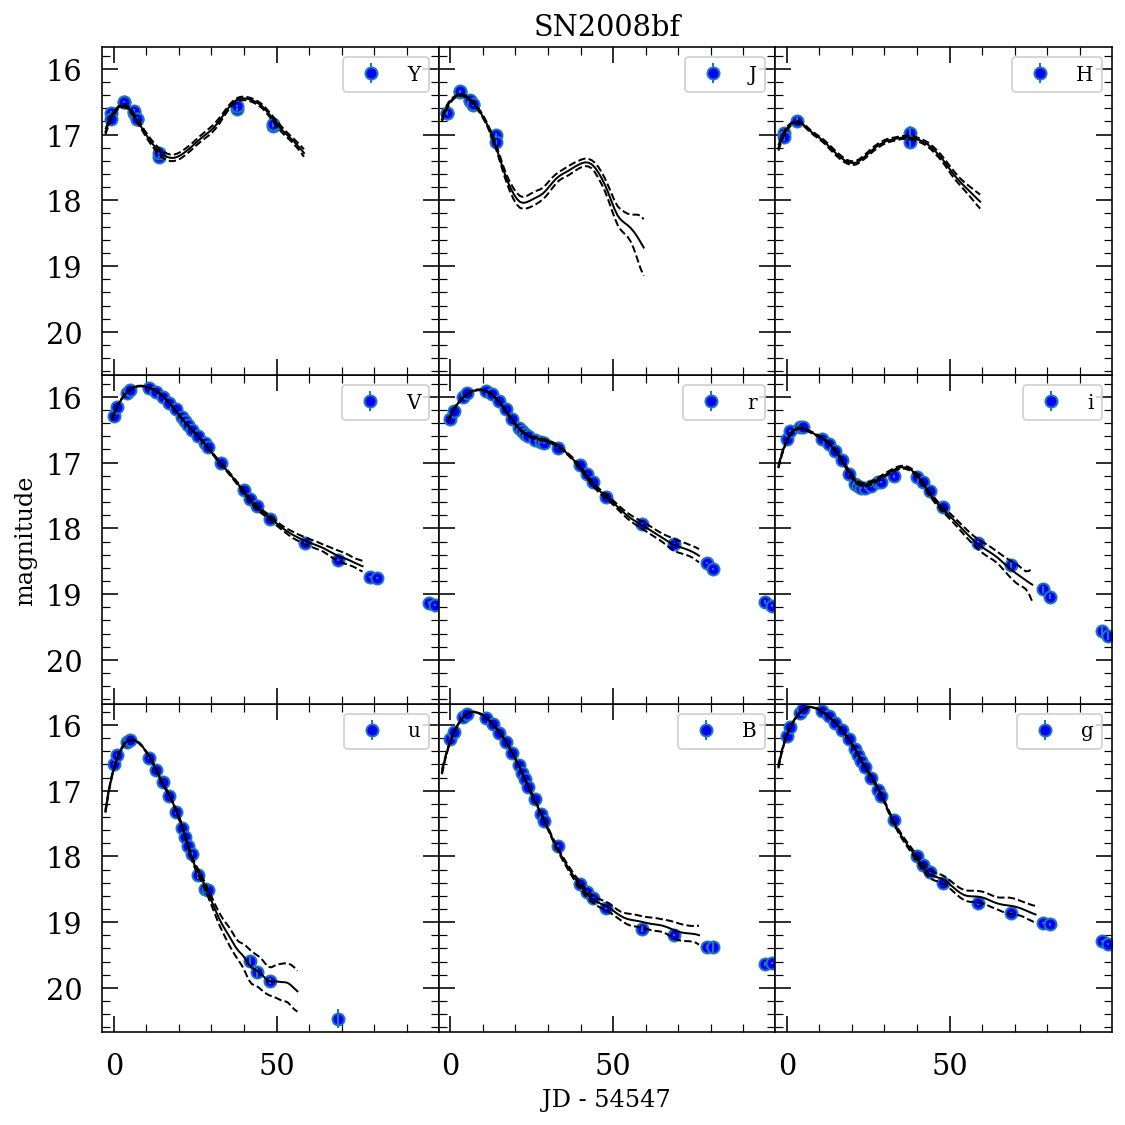

In [31]:
# SNe to remove
df1 = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
df2 = pd.read_csv('sne_wo_opt_max.txt', names=['name', 'comment'], delim_whitespace=True)
del_df = pd.concat([df1, df2])
files2remove = [f'{DATA_DIR}/{name}_snpy.txt' for name in list(del_df.name.values)]

sn_files = [file for file in glob.glob(f'{DATA_DIR}/*.txt') if file not in files2remove]
print(f'Fitting {len(sn_files)} SNe ({len(files2remove)} SNe removed using cuts)')

count = 0
failed_count = 0
with open('sne_wo_nir_max.txt', 'w') as fout:
    for sn_file in sn_files:
        sn = snpy.import_lc(sn_file)
        sn.choose_model(SNOOPY_MODEL)
        
        if sn.name=='SN2008fp':
            sn.data.pop('K')
            
        try:
            sn.fit()
        except Exception as message:
            split_mssg = message.args[0].split()
            if 'filter' in split_mssg:
                filt_ind = split_mssg.index('filter') + 1
                filt = split_mssg[filt_ind]
                if filt not in ['J', 'H']:
                    sn.data.pop(filt)
                    sn.fit()
                else:
                    print(f'Unable to fit {sn.name}: {message}')
                    fout.write(f'{sn.name} \tfit-failed\n')
                    failed_count += 1
                    continue  # skip this SN
            else:
                print(f'Unable to fit {sn.name}: {message}')
                fout.write(f'{sn.name} \tfit-failed\n')
                failed_count += 1
                continue  # skip this SN

        # check if there is NIR coverage before NIR max
        nir_peak_covered = False
        for band in sn.allbands():
            if band in ['J', 'H']:
                
                model_times = np.arange(sn.Tmax-20, sn.Tmax+40, 0.1)
                model_mag, _, mask = sn.model(band, model_times)
                model_phases  = model_times[mask]-sn.Tmax 
                model_mag = model_mag[mask]
                
                phases = sn.data[band].get_t()  # observed phases w.r.t. Tmax
                first_epoch = phases[0]
                last_epoch = phases[-1]
                
                peak_model_id = np.argmin(model_mag)
                peak_model_phase = model_phases[peak_model_id]

                if first_epoch<peak_model_phase and last_epoch>peak_model_phase:
                    nir_peak_covered = True
                    break

        # save the plots of the SNe w/o optical peak coverage
        if not nir_peak_covered:
            print(f'{sn.name} does not have coverage before NIR max')
            fout.write(f'{sn.name} \tno-peak-coverage\n')

            #sn.save(f'nir_cuts_fits/{sn.name}.snpy')
            sn.plot(outfile=f'nir_cuts_fits/{sn.name}.jpeg')
            count += 1

print(f'{count} SNe without NIR peak coverage and {failed_count} with failed fits.')

SN CSP15aae doesn't have data before NIR peak. The NIR light curves of SN2005ke and SN2006mr do not look normal (secondary peaks missing).

### save reference files

In [11]:
# SNe to remove
df1 = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
df2 = pd.read_csv('sne_wo_opt_max.txt', names=['name', 'comment'], delim_whitespace=True)
df3 = pd.read_csv('sne_wo_nir_max.txt', names=['name', 'comment'], delim_whitespace=True)
del_df = pd.concat([df1, df2, df3])
files2remove = [f'{DATA_DIR}/{name}_snpy.txt' for name in list(del_df.name.values)]

sn_files = [file for file in glob.glob(f'{DATA_DIR}/*.txt') if file not in files2remove]
print(f'{len(sn_files)} SNe left and {len(files2remove)} SNe removed after cuts')

# save reference files into an output file
with open('reference_files.txt', 'w') as outfile:
    for sn_file in sn_files:
        outfile.write(sn_file + '\n')

78 SNe left and 258 SNe removed after cuts
